In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
ton_iot_path = "/content/drive/MyDrive/MedSecureAI - Cybersecurity Team/MOP_UseCase11_Project/datasets/TON_IoT/Train_Test_datasets/Train_Test_Network_dataset/train_test_network.csv"

In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv(ton_iot_path)

# Preview the dataset
df.head()


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


**Common setup (imports, config, preprocessing)**

In [12]:
# Imports
import inspect, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)

# Config
TARGET = "label"                         # change if your target name differs
DROP_COLS = ["src_ip","dst_ip","timestamp","ts","uid"]  # drop IDs / free-text if present
TEST_SIZE = 0.3
RANDOM_STATE = 42
N_SPLITS = 5

# --- Prepare df ---
df = df.copy()
for c in DROP_COLS:
    if c in df.columns:
        df = df.drop(columns=c)
# remove almost-empty columns (robustness)
df = df[[c for c in df.columns if df[c].isna().mean() < 0.95]]

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

# dtype splits
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number","bool"]).columns.tolist()

# OneHotEncoder kw (sklearn >=1.2 uses sparse_output)
ohe_kwargs = {"handle_unknown":"ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = True
else:
    ohe_kwargs["sparse"] = True

# Preprocessing pipelines
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),  # sparse-friendly
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(**ohe_kwargs)),
])

preprocess = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)],
    remainder="drop",
    sparse_threshold=1.0
)

# Train/test split (stratified)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {X_tr.shape}, Test: {X_te.shape}, Pos rate train={y_tr.mean():.3f}")


Train: (147730, 41), Test: (63313, 41), Pos rate train=0.763


**Random Forest pipeline (train → evaluate → save)**

RF 5-fold F1: [1. 1. 1. 1. 1.] Mean: 1.0

=== RF TEST REPORT ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     15000
           1     1.0000    1.0000    1.0000     48313

    accuracy                         1.0000     63313
   macro avg     1.0000    1.0000    1.0000     63313
weighted avg     1.0000    1.0000    1.0000     63313

ROC-AUC: 1.0


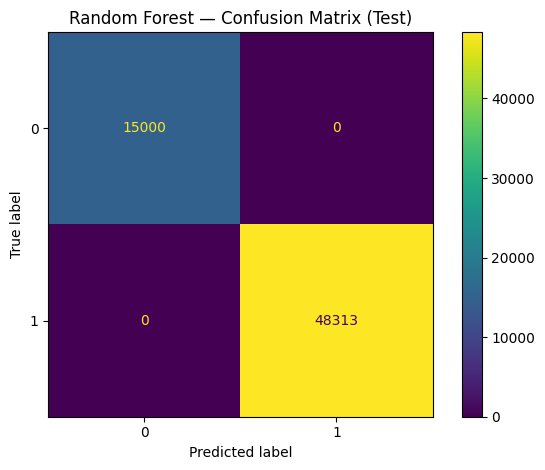

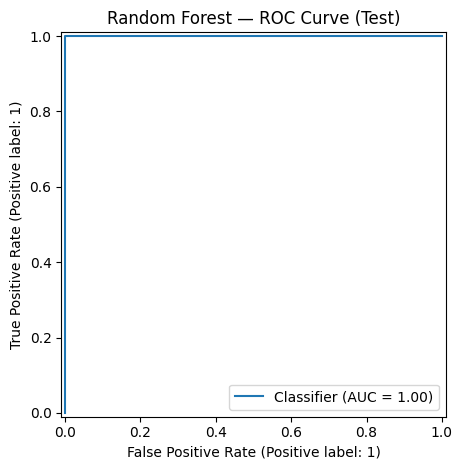

Saved: rf_ton_iot_pipeline.joblib


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Build pipeline
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
rf_pipe = Pipeline([("pre", preprocess), ("clf", rf)])

# CV F1 on train
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
cv_f1 = cross_val_score(rf_pipe, X_tr, y_tr, cv=cv, scoring="f1", n_jobs=-1)
print(f"RF {N_SPLITS}-fold F1:", cv_f1, "Mean:", cv_f1.mean())

# Fit and evaluate
rf_pipe.fit(X_tr, y_tr)
y_pred = rf_pipe.predict(X_te)

# Probabilities for AUC (call on PIPELINE, not the estimator)
try:
    y_prob = rf_pipe.predict_proba(X_te)[:,1]
    auc = roc_auc_score(y_te, y_prob)
except Exception:
    y_prob, auc = None, None

print("\n=== RF TEST REPORT ===")
print(classification_report(y_te, y_pred, digits=4))
print("ROC-AUC:", auc)

cm = confusion_matrix(y_te, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Random Forest — Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

if y_prob is not None:
    RocCurveDisplay.from_predictions(y_te, y_prob)
    plt.title("Random Forest — ROC Curve (Test)")
    plt.tight_layout(); plt.show()

# Save fitted pipeline
joblib.dump(rf_pipe, "rf_ton_iot_pipeline.joblib")
print("Saved: rf_ton_iot_pipeline.joblib")




Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best params: {'clf__colsample_bytree': np.float64(0.749816047538945), 'clf__gamma': np.float64(0.4753571532049581), 'clf__learning_rate': np.float64(0.14907884894416698), 'clf__max_depth': 7, 'clf__min_child_weight': 5, 'clf__n_estimators': 402, 'clf__reg_lambda': np.float64(1.3916655057071823), 'clf__scale_pos_weight': 1.0, 'clf__subsample': np.float64(0.6399899663272012)}
Best CV F1: 1.0
XGB 5-fold F1 (post-tune): [1. 1. 1. 1. 1.] Mean: 1.0

=== XGB TEST REPORT ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     15000
           1     1.0000    1.0000    1.0000     48313

    accuracy                         1.0000     63313
   macro avg     1.0000    1.0000    1.0000     63313
weighted avg     1.0000    1.0000    1.0000     63313

ROC-AUC: 1.0


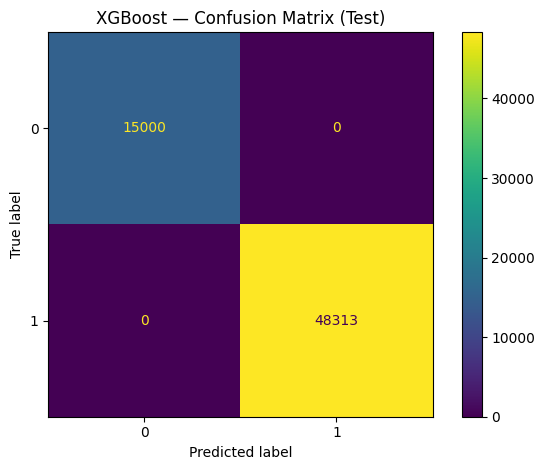

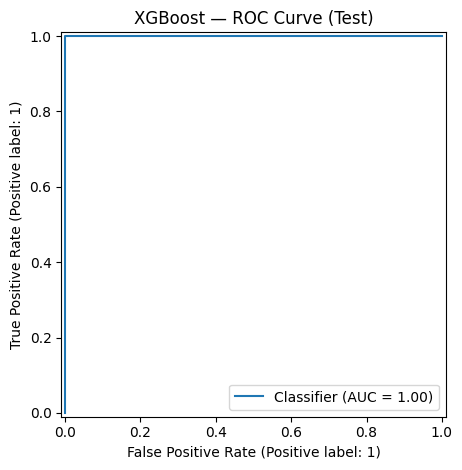

Saved: xgb_ton_iot_pipeline.joblib


In [14]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Base estimator
xgb_base = xgb.XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
)

xgb_pipe = Pipeline([("pre", preprocess), ("clf", xgb_base)])

# imbalance heuristic
pos, neg = y_tr.sum(), len(y_tr) - y_tr.sum()
scale_pos_weight = max(1.0, neg / max(1, pos))

param_dist = {
    "clf__n_estimators": randint(300, 800),
    "clf__learning_rate": uniform(0.01, 0.19),
    "clf__max_depth": randint(3, 11),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.6, 0.4),
    "clf__min_child_weight": randint(1, 8),
    "clf__gamma": uniform(0.0, 0.5),
    "clf__reg_lambda": uniform(0.5, 2.0),
    "clf__scale_pos_weight": [scale_pos_weight],
}

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=25,              # increase if you want more thorough tuning
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
)

search.fit(X_tr, y_tr)
print("\nBest params:", search.best_params_)
print("Best CV F1:", search.best_score_)

best_xgb = search.best_estimator_

# Post-tune CV sanity
cv_f1_xgb = cross_val_score(best_xgb, X_tr, y_tr, cv=cv, scoring="f1", n_jobs=-1)
print(f"XGB {N_SPLITS}-fold F1 (post-tune):", cv_f1_xgb, "Mean:", cv_f1_xgb.mean())

# Test eval
y_pred = best_xgb.predict(X_te)
y_prob = best_xgb.predict_proba(X_te)[:,1]
auc = roc_auc_score(y_te, y_prob)

print("\n=== XGB TEST REPORT ===")
print(classification_report(y_te, y_pred, digits=4))
print("ROC-AUC:", auc)

cm = confusion_matrix(y_te, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("XGBoost — Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

RocCurveDisplay.from_predictions(y_te, y_prob)
plt.title("XGBoost — ROC Curve (Test)")
plt.tight_layout(); plt.show()

# Save fitted pipeline
joblib.dump(best_xgb, "xgb_ton_iot_pipeline.joblib")
print("Saved: xgb_ton_iot_pipeline.joblib")


In [15]:
from sklearn.utils.validation import check_is_fitted

rf_model  = joblib.load("rf_ton_iot_pipeline.joblib")
xgb_model = joblib.load("xgb_ton_iot_pipeline.joblib")

# should NOT raise
check_is_fitted(rf_model)
check_is_fitted(xgb_model)
print("Pipelines are fitted.")

# Predict on a sample row (same schema used for training)
sample = df.drop(TARGET, axis=1).iloc[[0]]
print("RF Prediction:",  int(rf_model.predict(sample)[0]))
print("XGB Prediction:", int(xgb_model.predict(sample)[0]))


Pipelines are fitted.
RF Prediction: 1
XGB Prediction: 1


In [16]:
from google.colab import files

files.download("rf_ton_iot_pipeline.joblib")
files.download("xgb_ton_iot_pipeline.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>